In [1]:
import numpy as np
from devito import (Function, TimeFunction, cos, sin, solve,
                    Eq, Operator, configuration, norm)
from examples.seismic import TimeAxis, RickerSource, Receiver, demo_model
from examples.seismic.model import SeismicModel
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.size'] = 12
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [3]:

# NBVAL_IGNORE_OUTPUT   
nx = 101
ny = 101
nz = 101
shape   = (nx,ny,nz) 
spacing = (10.,10.,10.) # spacing of 10 meters
origin  = (0.,0.,0.)  
nbl = 0  # number of pad points
sorder=2
torder=2

# # initialize Thomsem parameters to those used in Mu et al., (2020)
vp = 3
eps =0.24
delt=0.1
#sigma = (vp*vp)/(vs*vs)*(epsilon - delta)
#sigma = float('inf')
#sigma = 6
#sigma = 1.5
sigma = 0.75
vs2 = (vp*vp)*(eps - delt)/(sigma)
vti_f = 1 - (eps - delt)/(sigma)

freq_rickers = 0.005
freq = freq_rickers *1# 2.5


model = SeismicModel(space_order=sorder, vp=vp, origin=origin, shape=shape,
                      dtype=np.float32, spacing=spacing, nbl=nbl, epsilon=eps,
                      delta=delt, theta=0., phi=None, bcs="damp")

# Get symbols from model
theta = model.theta
delta = model.delta
epsilon = model.epsilon
m = model.m

In [4]:

# Compute the dt and set time range
t0 = 0.   #  Simulation time start
tn = 500. #  Simulation time end (0.15 second = 150 msec)
dt = model.critical_dt
# dt = (dvalue/(np.pi*vmax))*np.sqrt(1/(1+etamax*(max_cos_sin)**2)) # eq. above (cell 3)
time_range = TimeAxis(start=t0,stop=tn,step=dt)
print("time_range; ", time_range)


time_range;  TimeAxis: start=0, stop=500.05, step=1.37, num=366


In [5]:

# NBVAL_IGNORE_OUTPUT

# time stepping 
p = TimeFunction(name="p", grid=model.grid, time_order=torder, space_order=sorder) #, save=time_range.num)
q = TimeFunction(name="q", grid=model.grid, time_order=torder, space_order=sorder) # space order 4?

# Main equations
term_p = (1 + 2*epsilon)*(p.dx2 + p.dy2) + q.dz2 - (vti_f - 1)*(p.dz2 - q.dz2)
term_q = (1 + 2*delta)*(p.dx2 + p.dy2)   + q.dz2 + (vti_f - 1)*(p.dx2  + p.dy2 - q.dx2  - q.dy2)

stencil_p = solve(m*p.dt2 - term_p, p.forward)
update_p = Eq(p.forward, stencil_p)

stencil_q = solve(m*q.dt2 - term_q, q.forward)
update_q = Eq(q.forward, stencil_q)

# set source and receivers
src = RickerSource(name='src',grid=model.grid,f0=freq,npoint=1,time_range=time_range)
src.coordinates.data[:,0] = model.domain_size[0]* .5
src.coordinates.data[:,1] = model.domain_size[1]* .5
src.coordinates.data[:,2] = model.domain_size[2]* .5
# Define the source injection
src_term = src.inject(field=p.forward,expr=src * dt**2 / m)
src_term_q = src.inject(field=q.forward,expr=src * dt**2 / m)

rec  = Receiver(name='rec',grid=model.grid,npoint=shape[0],time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(model.origin[0],model.domain_size[0], num=model.shape[0])
rec.coordinates.data[:, 1] = 2*spacing[1]
rec.coordinates.data[:, 2] = 2*spacing[1]
# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)
# Operators
optime=Operator([update_p] + [update_q] + src_term  + src_term_q+rec_term)


In [6]:
# you can print the generated code for both operators by typing print(optime) and print(oppres)
optime(time=time_range.num-2, dt=model.critical_dt)



Operator `Kernel` ran in 0.88 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.8753019999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.00020699999999999953, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.003373999999999989, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

365
Saving figure as ... devito-fletcher-3D-sigma0.75.png
done


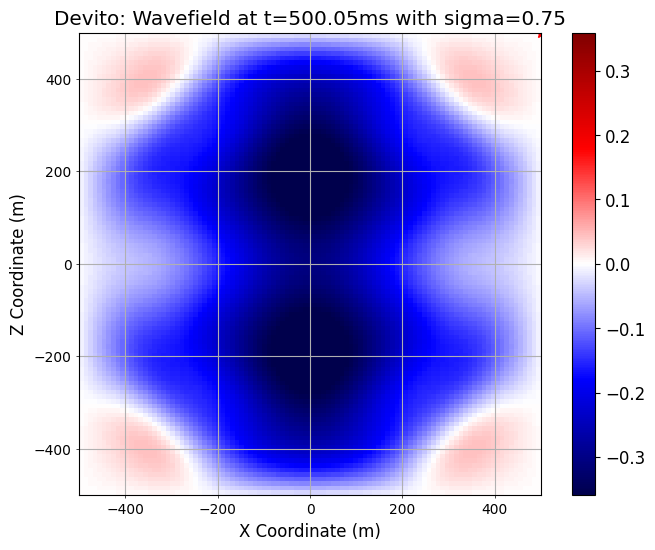

In [8]:

# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad,nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad   = np.array(shape) + 2 * nbl
origin_pad  = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

# Plot

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0] - extent_pad[0]/2, origin_pad[0] + extent_pad[0]/2,
              origin_pad[1] - extent_pad[1]/2, origin_pad[1] + extent_pad[1]/2]


time_target = 820
iy = int(ny/2)
ndt = p.data.shape[0]
it = np.minimum(int(time_target/dt), ndt-1)
time = it*dt
print(str(it))
amax1 = 0.05 * np.max(np.abs(p.data[it,:,:]))
amax2=np.percentile(np.abs(p.data[it,::]), 99.5)


fig, ax = plt.subplots(figsize=(800*px, 600*px))
pos = ax.imshow(np.transpose(p.data[it,:,iy,:]), cmap="seismic", vmin=-amax2, vmax=+amax2, extent=plt_extent)
ax.plot(model.domain_size[0]*.5, model.domain_size[1]* .5, \
       'red', linestyle='None', marker='*', markersize=8, label="Source")
ax.tick_params('both', length=2, width=0.5, which='major',labelsize=10)
ax.set_title("Devito: Wavefield at t="+str(format(time, '.2f'))+"ms with sigma="+str(sigma))
ax.set_xlabel("X Coordinate (m)")
ax.set_ylabel("Z Coordinate (m)")
ax.grid()
fig.colorbar(pos, ax=ax)

figtitle = "devito-fletcher-3D-sigma"+str(sigma)+".png"
print("Saving figure as ... " + figtitle)
fig.savefig(figtitle)
print("done")

###